# Preprocessing

## 1. Importing necessary libraries and data

In [48]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.insert(0, parent_dir)
sys.path = list(dict.fromkeys(sys.path))

In [49]:
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")

Primary check-ups

In [50]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [51]:
missing_df = pd.DataFrame(train.isnull().sum(), columns = ['missing_count'])
missing_df['missing_percentage'] = missing_df['missing_count'].apply(lambda x: round(x * 100/train.shape[0], 2))
print(missing_df)


             missing_count  missing_percentage
PassengerId              0                0.00
Survived                 0                0.00
Pclass                   0                0.00
Name                     0                0.00
Sex                      0                0.00
Age                    177               19.87
SibSp                    0                0.00
Parch                    0                0.00
Ticket                   0                0.00
Fare                     0                0.00
Cabin                  687               77.10
Embarked                 2                0.22


In [52]:
print(train.describe(include = 'all'))

        PassengerId    Survived      Pclass                     Name   Sex  \
count    891.000000  891.000000  891.000000                      891   891   
unique          NaN         NaN         NaN                      891     2   
top             NaN         NaN         NaN  Braund, Mr. Owen Harris  male   
freq            NaN         NaN         NaN                        1   577   
mean     446.000000    0.383838    2.308642                      NaN   NaN   
std      257.353842    0.486592    0.836071                      NaN   NaN   
min        1.000000    0.000000    1.000000                      NaN   NaN   
25%      223.500000    0.000000    2.000000                      NaN   NaN   
50%      446.000000    0.000000    3.000000                      NaN   NaN   
75%      668.500000    1.000000    3.000000                      NaN   NaN   
max      891.000000    1.000000    3.000000                      NaN   NaN   

               Age       SibSp       Parch  Ticket        Fare 

check list
- Age, Cabin, Embarked has missing values (missing at random? especially Age and Cabin)
- Age, SibSp, Parch, Fare all right-skewed. Would it be better to replace them with categorical variables instead?
- Title (e.g. Mr., Mrs.) is included in Name. Can this help?
- Pclass: keep as ordinal or categorical?
- Explore Cabin column (top value looks unusual)
- Ticket is not unique for all passengers
- Sex has unique values of 2. change it to int

## 2. Feature Engineering

In [53]:
preprocessing_func = []

#### 1. extracting titles from Name

In [54]:
def get_name_title(X):
    X = X.copy()
    X['transformed'] = [re.search(r", (.*?)\.", x).group(1) for x in X.iloc[:,0]]
    return X[['transformed']]

train['name_title'] = get_name_title(train[['Name']])
train['name_title'].value_counts()


name_title
Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
the Countess      1
Capt              1
Ms                1
Sir               1
Lady              1
Mme               1
Don               1
Jonkheer          1
Name: count, dtype: int64

In [55]:
preprocessing_func.append('get_cabin_share_flg')

#### 1a) name_title to special_title_flg (0=generic (Mr, Mrs, Miss, Ms), 1=special (Sir, Master, ...))

In [56]:
def get_special_title_flg(X):
    X = get_name_title(X)
    X['transformed'] = ['generic' if x in ['Mr', 'Miss', 'Mrs', 'Ms'] else 'special' for x in X.iloc[:,0]]
    return X[['transformed']]

train['special_title_flg'] = get_special_title_flg(train[['Name']])
train['special_title_flg'].value_counts()

special_title_flg
generic    825
special     66
Name: count, dtype: int64

In [57]:
preprocessing_func.append(('get_special_title_flg', 'Name'))

#### 2) family_flg
- SibSp=0 & Parch=0 -> "no_fam"
- SibSp>0 & Parch=0 -> "SibSp"
- SibSp=0 & Parch>0 -> "Parch"
- SibSp>0 & Parch>0 -> "big_fam"

In [58]:
def family_onboard(X):
    if X['SibSp'] == 0 and X['Parch'] == 0:
        return 'no_fam'
    elif X['SibSp'] > 0 and X['Parch'] == 0:
        return 'SibSp'
    elif X['SibSp'] == 0 and X['Parch'] > 0:
        return 'Parch'
    elif X['SibSp'] > 0 and X['Parch'] > 0:
        return 'big_fam'
    else:
        return 'NA'

def get_family_flg(X):
    return X.apply(lambda x: family_onboard(x), axis=1).to_frame()

train['family_flg'] = get_family_flg(train[['SibSp','Parch']])
train['family_flg'].value_counts()

family_flg
no_fam     537
big_fam    142
SibSp      141
Parch       71
Name: count, dtype: int64

In [59]:
preprocessing_func.append(('get_family_flg', "'SibSp','Parch'"))

#### 3) Cabin
First need to explore the data values

In [60]:
train['Cabin'].value_counts()

Cabin
B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
              ..
E34            1
C7             1
C54            1
E36            1
C148           1
Name: count, Length: 147, dtype: int64

#### 3a) cabin_count
Looks like Cabin column consist of alpha-numerical values. It also looks like multiple rooms were assigned to some passengers. Rooms separated by space. Will create 'cabin_count' based on this info

In [61]:
def get_cabin_count(X):
    X = X.copy()
    X['transformed'] = [0 if x is np.nan else len(x.split(' ')) for x in X.iloc[:,0]]
    return X[['transformed']]

train['cabin_count'] = get_cabin_count(train[['Cabin']])
train['cabin_count'].value_counts()

cabin_count
0    687
1    180
2     16
3      6
4      2
Name: count, dtype: int64

In [62]:
preprocessing_func.append(('get_cabin_count', 'Cabin'))

#### 3b) cabin_flg
since only a few passengers are assigned to more than 3 cabins, could be better to create 'cabin_flg' where:
- cabin_count=0 -> "no_cabin"
- cabin_count=1 -> "one_cabin"
- cabin_count>1 -> "many_cabins"

In [63]:
def get_cabin_flg(X):
    X = get_cabin_count(X)
    X['transformed'] = ["no_cabin" if x==0 else "one_cabin" if x==1 else "many_cabins" for x in X.iloc[:,0]]
    return X[['transformed']]

train['cabin_flg'] = get_cabin_flg(train[['Cabin']])
train['cabin_flg'].value_counts()

cabin_flg
no_cabin       687
one_cabin      180
many_cabins     24
Name: count, dtype: int64

there are too little data points for many_cabins. should cabin_flg be "has cabin/doesn't have cabin" feature instead?

need to check the data count against the target

In [64]:
import scipy.stats as stats
ct = pd.crosstab(train['cabin_flg'], train['Survived'])
print(ct)
res = stats.chi2_contingency(ct)
print(res.expected_freq)
print(res.pvalue)

Survived       0    1
cabin_flg            
many_cabins   10   14
no_cabin     481  206
one_cabin     58  122
[[ 14.78787879   9.21212121]
 [423.3030303  263.6969697 ]
 [110.90909091  69.09090909]]
2.4830995139487514e-20


cabin_flg seems significant in predicting the survival. 
and since many_cabins and one_cabin seem to have same trend (more leaned toward survived) so it could be better to combine the two field and go with "has cabin/ doesn't have cabin" feature


In [65]:
def get_cabin_flg(X):
    X = X.copy()
    X['transformed'] = ["no_cabin" if x is np.nan else "has_cabin" for x in X.iloc[:,0]]
    return X[['transformed']]

train['cabin_flg'] = get_cabin_flg(train[['Cabin']])
train['cabin_flg'].value_counts()

cabin_flg
no_cabin     687
has_cabin    204
Name: count, dtype: int64

In [66]:
preprocessing_func.append(('get_cabin_flg', 'Cabin'))

#### 3c) cabin_share_flg
Looks like some cabins are shared between passengers. Will create 'cabin_share_flg' where:
- passenger_count=1 -> "private"
- passenger_count>1 -> "shared"
- no cabin -> "no_cabin"

In [67]:
def get_cabin_share_flg(X):
    count_df = X.value_counts()
    merged = pd.merge(X, count_df, how='left', on=['Cabin'])
    merged['transformed'] = ["private" if x==1 else "shared" if x>1 else 'no_cabin' for x in merged.iloc[:,-1]]
    return merged[['transformed']]

train['cabin_share_flg']=get_cabin_share_flg(train[['Cabin']])
train['cabin_share_flg'].value_counts()

cabin_share_flg
no_cabin    687
shared      103
private     101
Name: count, dtype: int64

In [68]:
preprocessing_func.append(('get_cabin_share_flg', 'Cabin'))

#### 4) Ticket
Check which ticket number is being repeated

In [69]:

def get_ticket_share_flg(X):
    count_df = X.iloc[:,0].value_counts()
    merged = pd.merge(X, count_df, how='left', on=['Ticket'])
    merged['transformed'] = ['unshared' if x==1 else 'shared' for x in merged.iloc[:,-1]]
    return merged[['transformed']]

get_ticket_share_flg(train[['Ticket']])
train['ticket_share_flg'] = get_ticket_share_flg(train[['Ticket']])
train['ticket_share_flg'].value_counts()

ticket_share_flg
unshared    547
shared      344
Name: count, dtype: int64

check list
- is ticket_share_flg related to 
    - family_flg?
    - cabin_flg?
    - cabin_share_flg?

In [70]:
preprocessing_func.append(('get_ticket_share_flg', 'Ticket'))

In [71]:
pd.crosstab(train['ticket_share_flg'],train['family_flg'], normalize='all')

family_flg,Parch,SibSp,big_fam,no_fam
ticket_share_flg,,,,
shared,0.057239,0.098765,0.145903,0.084175
unshared,0.022447,0.059484,0.013468,0.518519


In [72]:
pd.crosstab(train['ticket_share_flg'],train['cabin_flg'], normalize='all')

cabin_flg,has_cabin,no_cabin
ticket_share_flg,,
shared,0.129068,0.257015
unshared,0.099888,0.514029


In [73]:
pd.crosstab(train['ticket_share_flg'],train['cabin_share_flg'], normalize='all')

cabin_share_flg,no_cabin,private,shared
ticket_share_flg,,,
shared,0.257015,0.038159,0.090909
unshared,0.514029,0.075196,0.024691


It can be seens that proportion of shared tickets were the highest at 
- family_flg=big_fam
- cabin_flg=no_cabin
- cabin_share_flg=no_cabin

The imbalance of no_cabin to other values in 'cabin_flg' and 'cabin_share_flg' could be the reason behind this result.

Could be benefitial to explore the interaction between these flg columns.

#### 5) fare_flg
It seems there are passengers who paid 0 for their Fare.
Check how many actually went onboard with no charge

In [74]:
def get_fare_flg(X):
    X = X.copy()
    X['transformed'] = ['free' if x==0 else 'paid' for x in X.iloc[:,0]]
    return X[['transformed']]

train['fare_flg'] = get_fare_flg(train[['Fare']])
train['fare_flg'].value_counts(normalize='column')

fare_flg
paid    0.983165
free    0.016835
Name: proportion, dtype: float64

Only 1.6% of the passengers had 0 Fare, so no special flag will be assigned and will be treated as low fare


Fare will be divided in to 3 equal-sized bin and assign fare_flg based on the bin interval:
- Fare in the first price range -> "low"
- Fare in the middle price range -> " mid"
- Fare in the last price range -> "high"

In [75]:
def get_fare_flg(X):
    return pd.qcut(X.iloc[:,0], q=3, labels=['low', 'mid', 'high'])
train['fare_flg'] = get_fare_flg(train[['Fare']])
train['fare_flg'].value_counts()

fare_flg
low     308
high    295
mid     288
Name: count, dtype: int64

<Axes: xlabel='fare_flg', ylabel='count'>

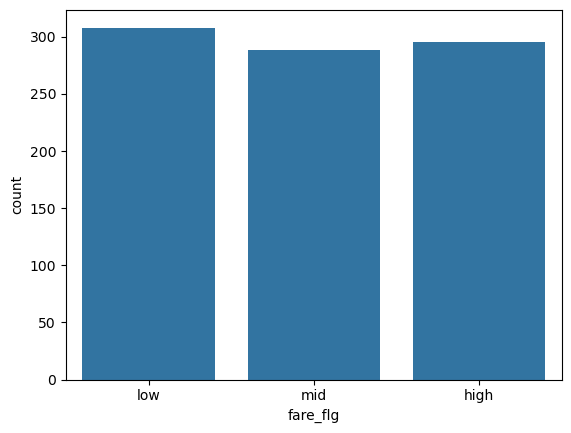

In [76]:
sns.barplot(train['fare_flg'].value_counts()[:20])

In [77]:
preprocessing_func.append(('get_fare_flg', 'Fare'))

## 3) Univariate Analysis

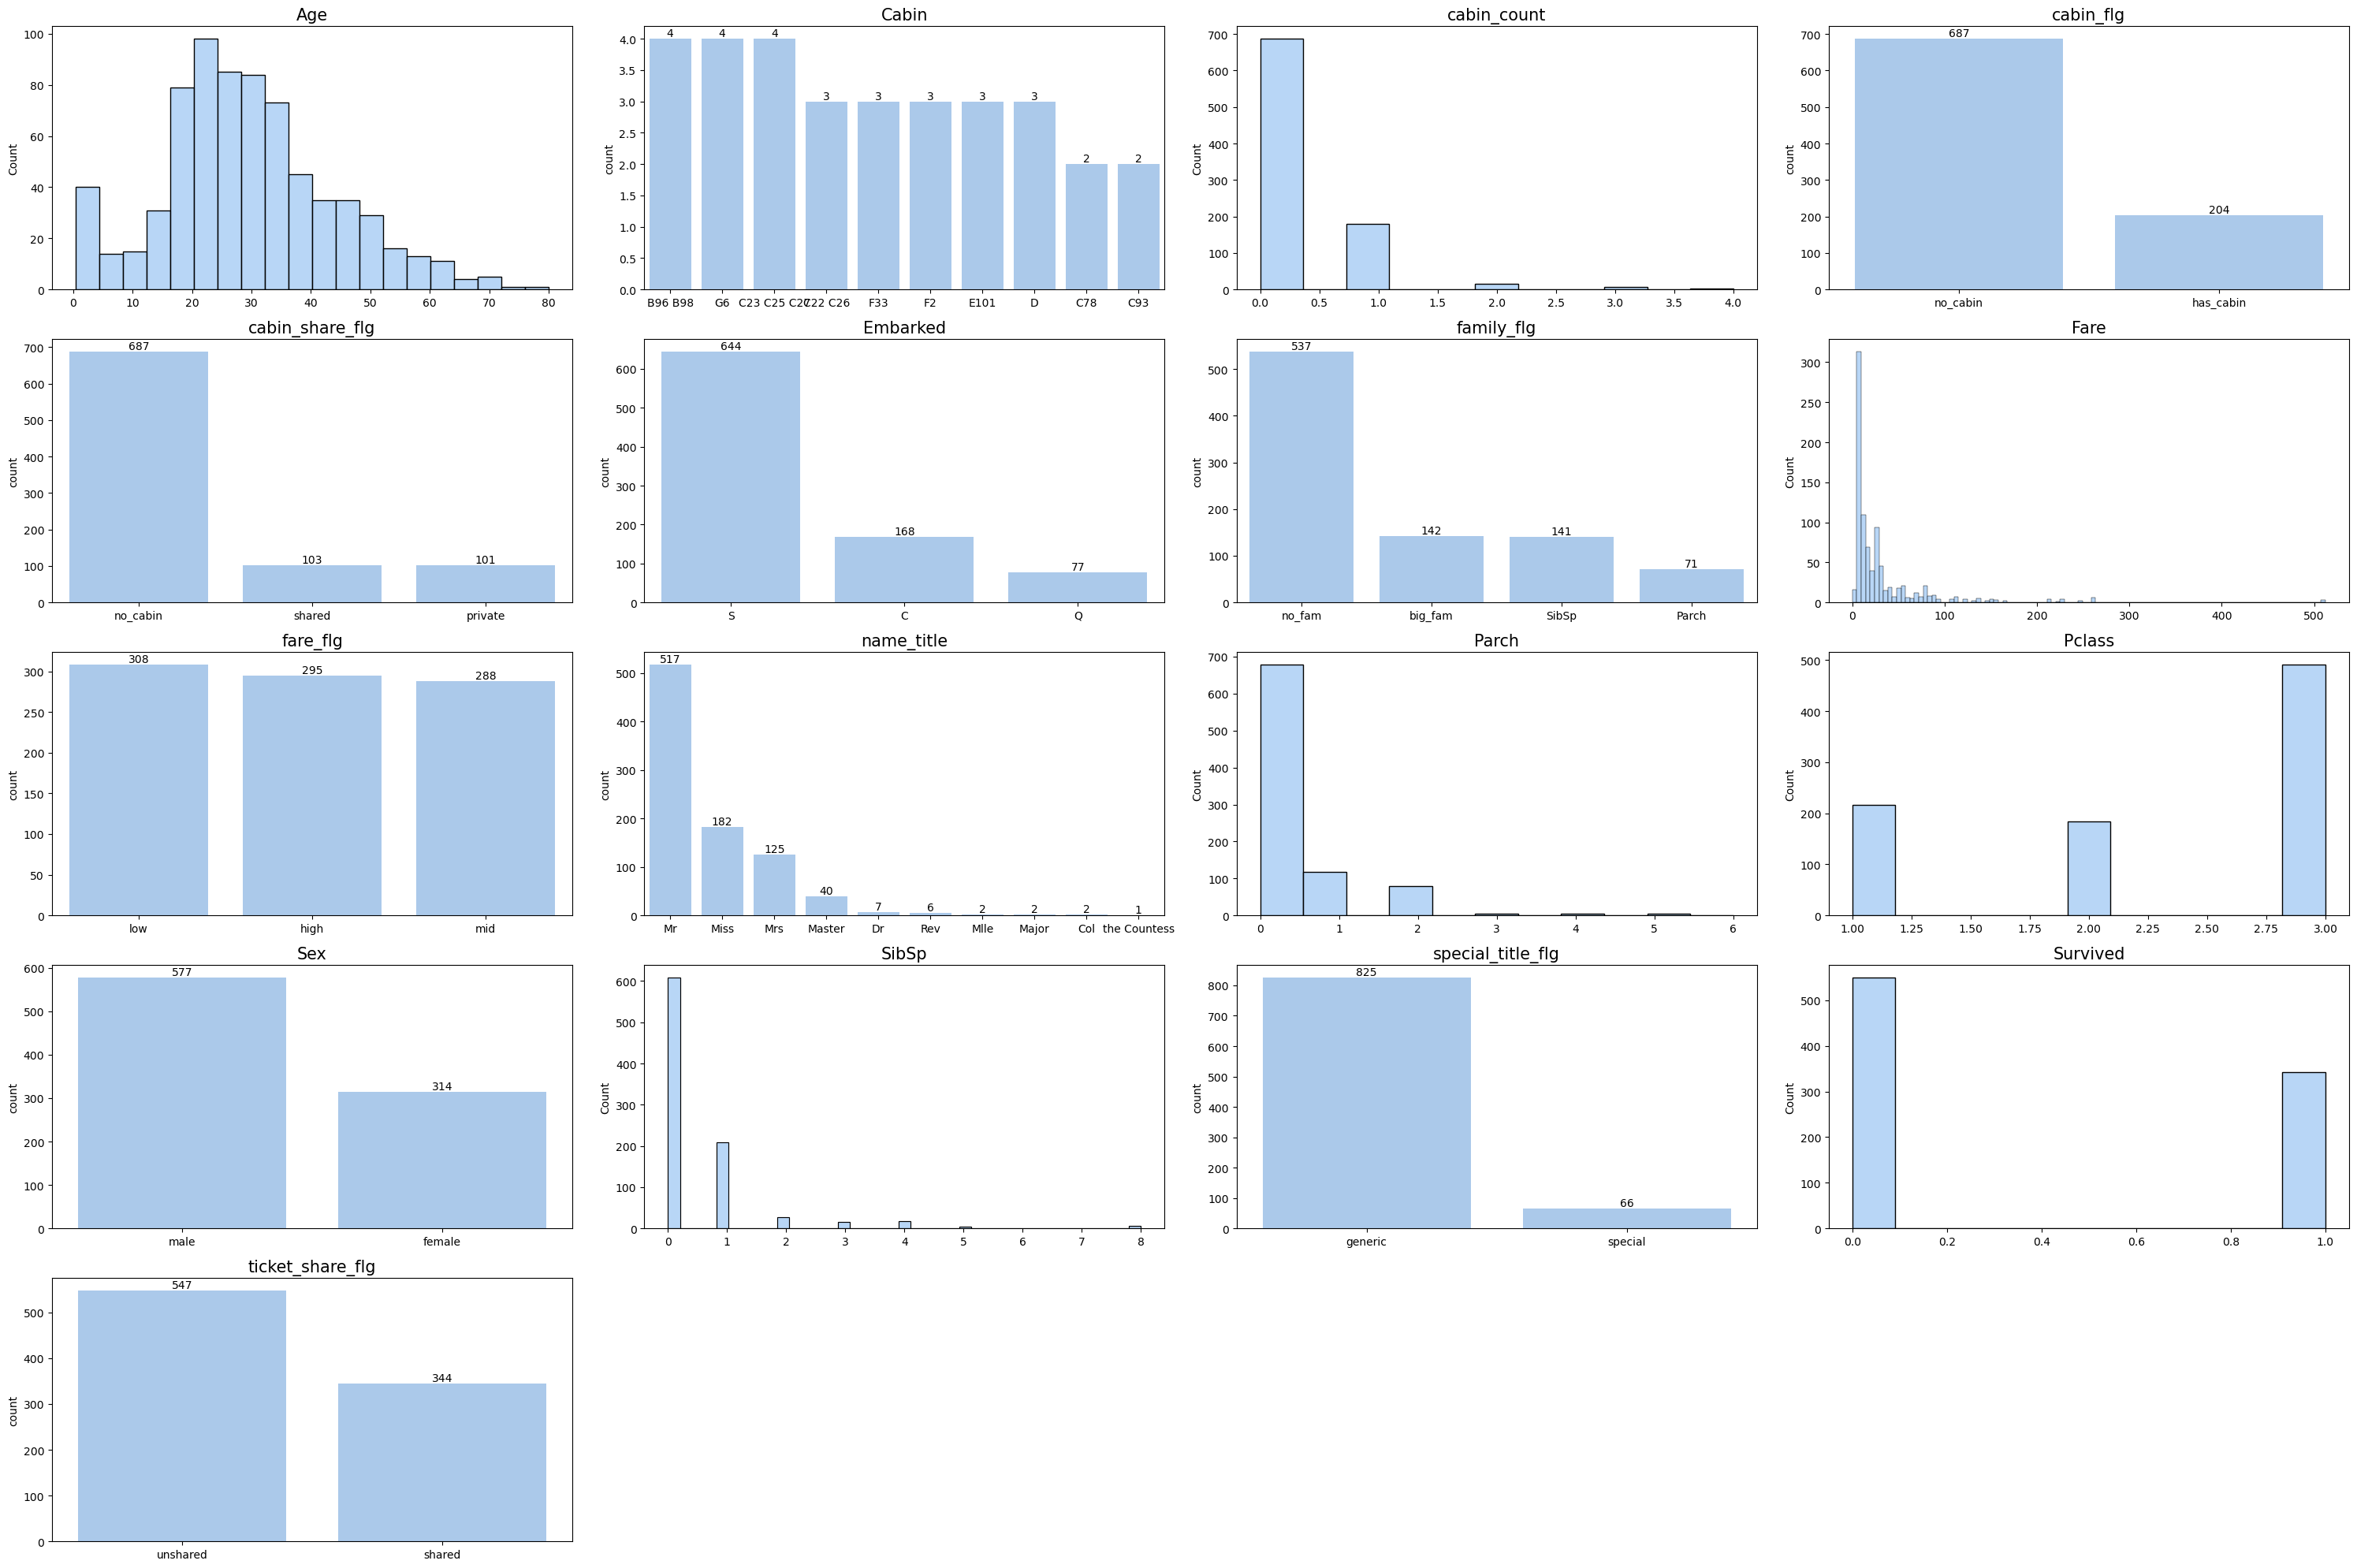

In [78]:
from modules.eda.plots import Univariate
# test = sns.color_palette("")
sns.set_palette("pastel")

feature_columns = list(set(train.columns).difference(set(['PassengerId','Name','Ticket'])))
feature_columns = sorted(feature_columns, key=str.casefold)

Univariate(figsize = (30,20), ncol = 4).plot(train[feature_columns])


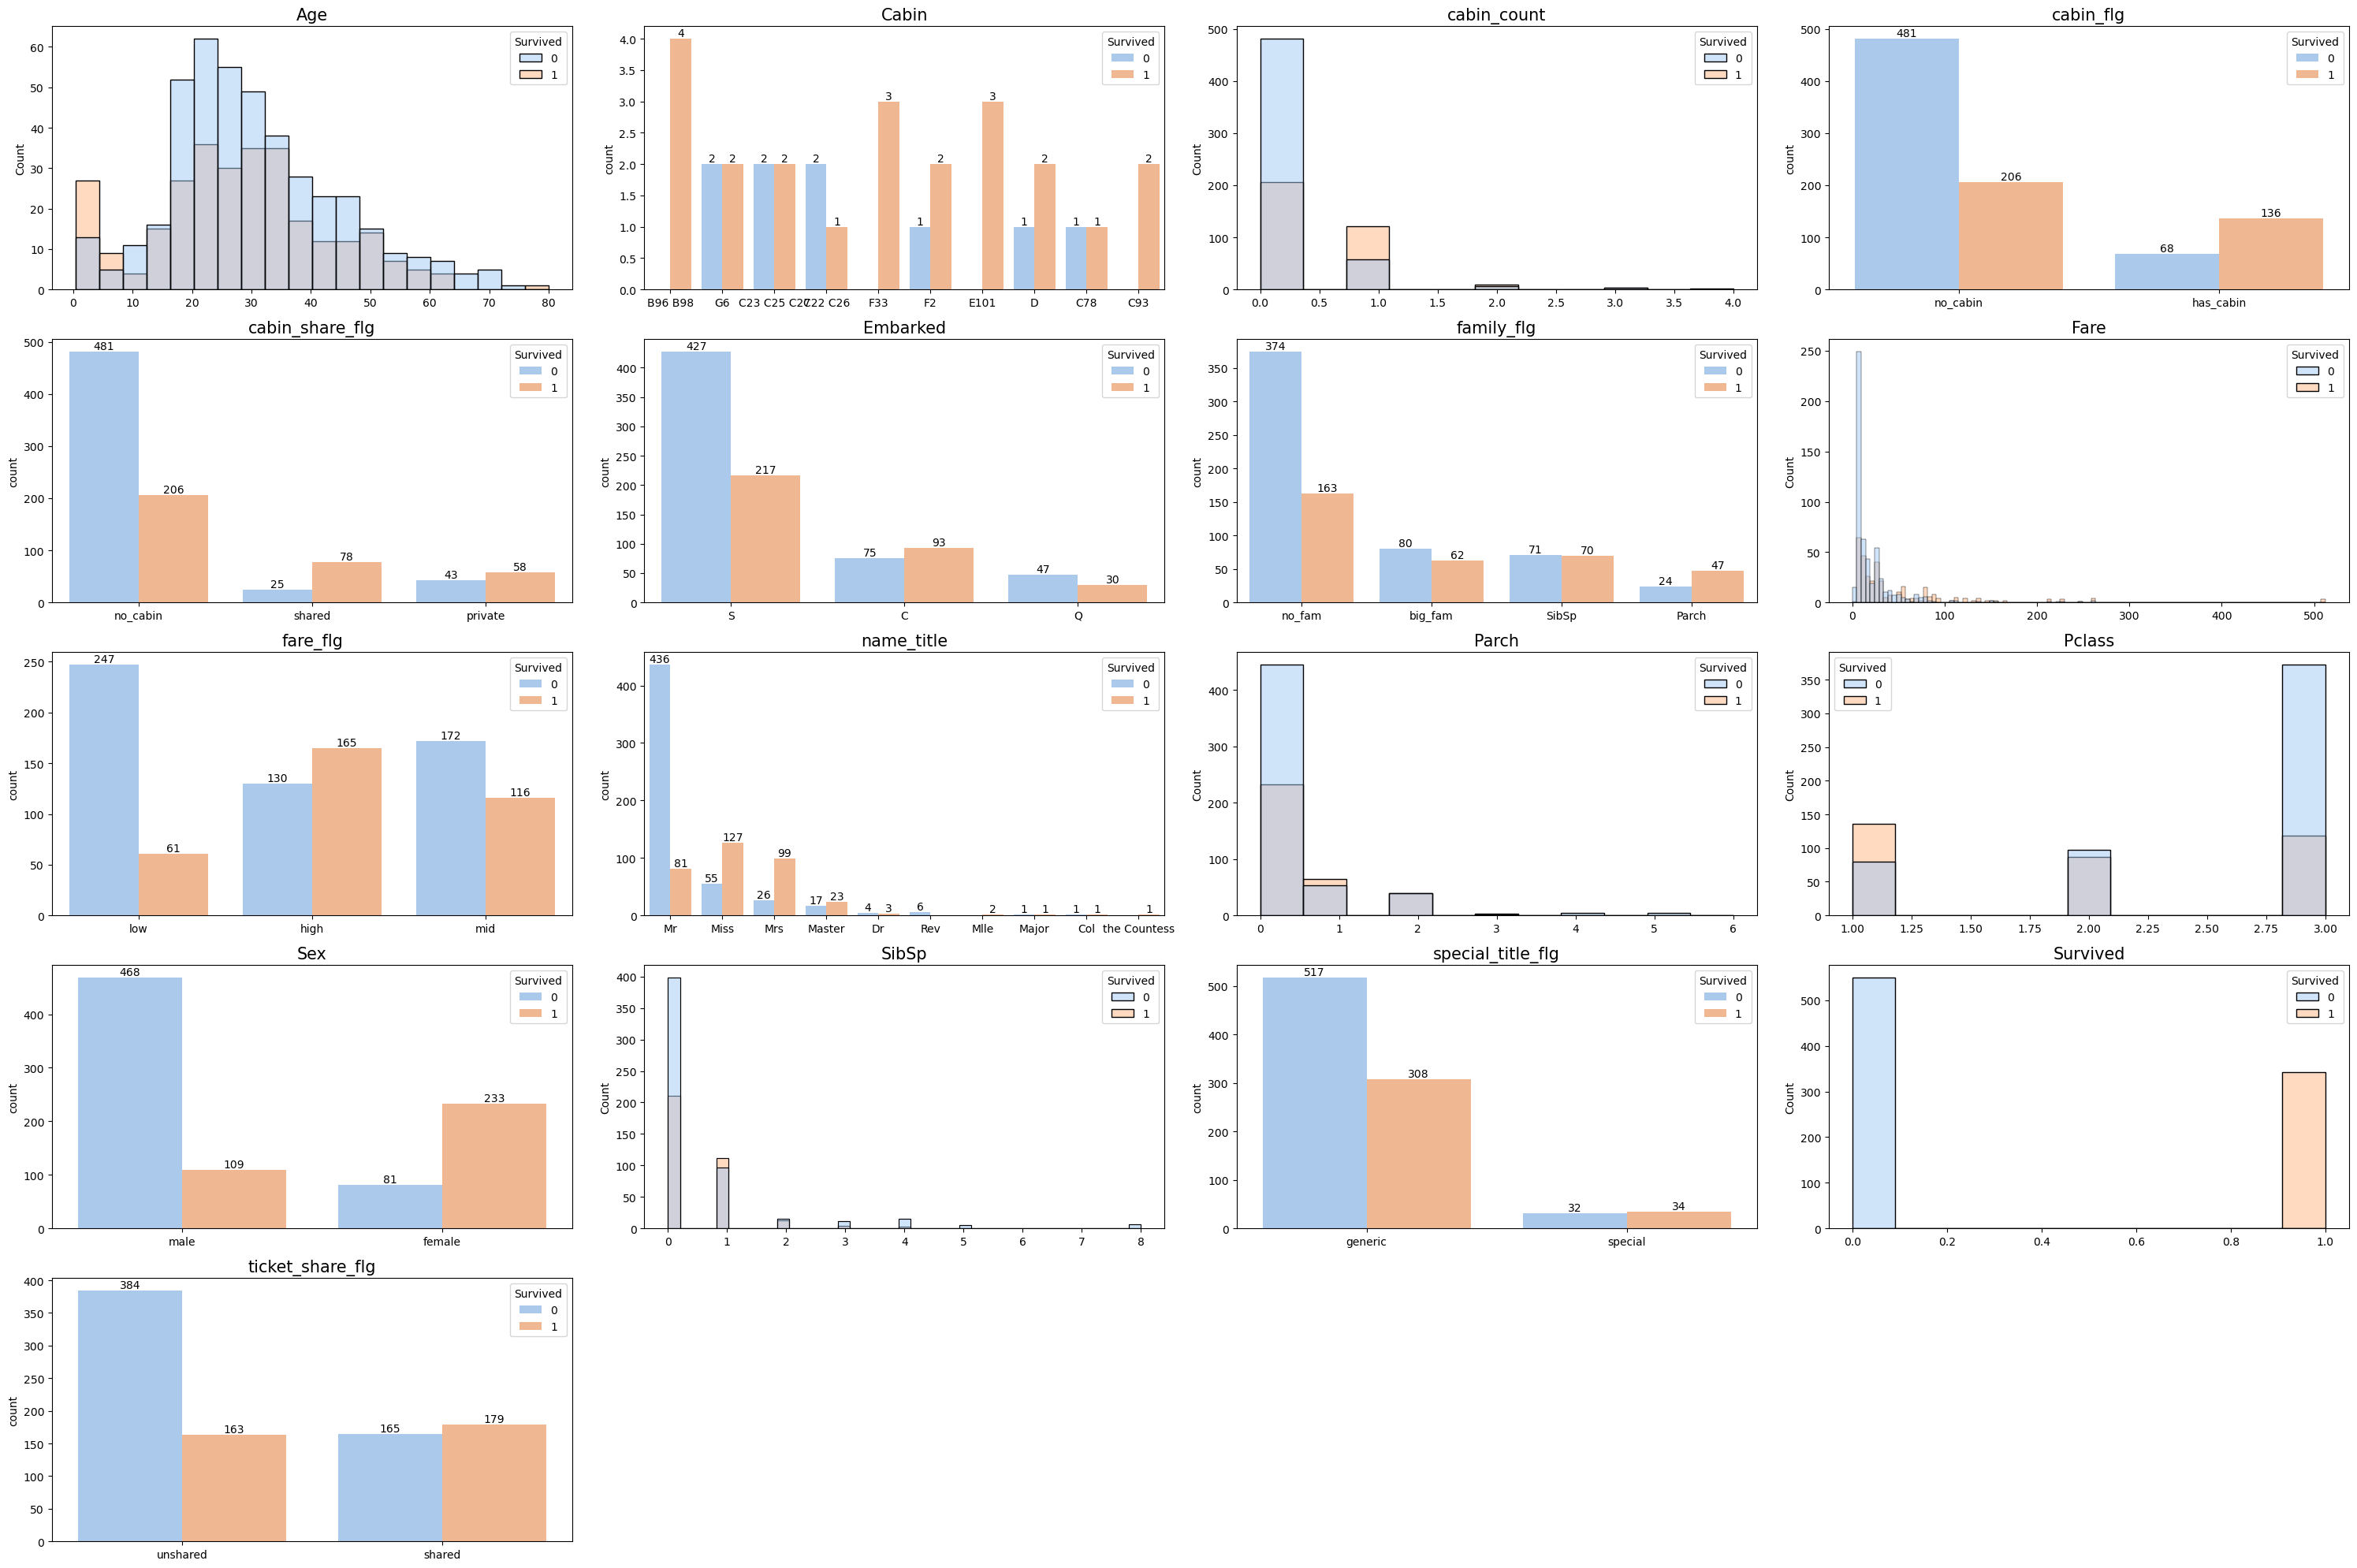

In [79]:
Univariate(figsize = (30,20), ncol = 4).plot(train[feature_columns], hue='Survived')

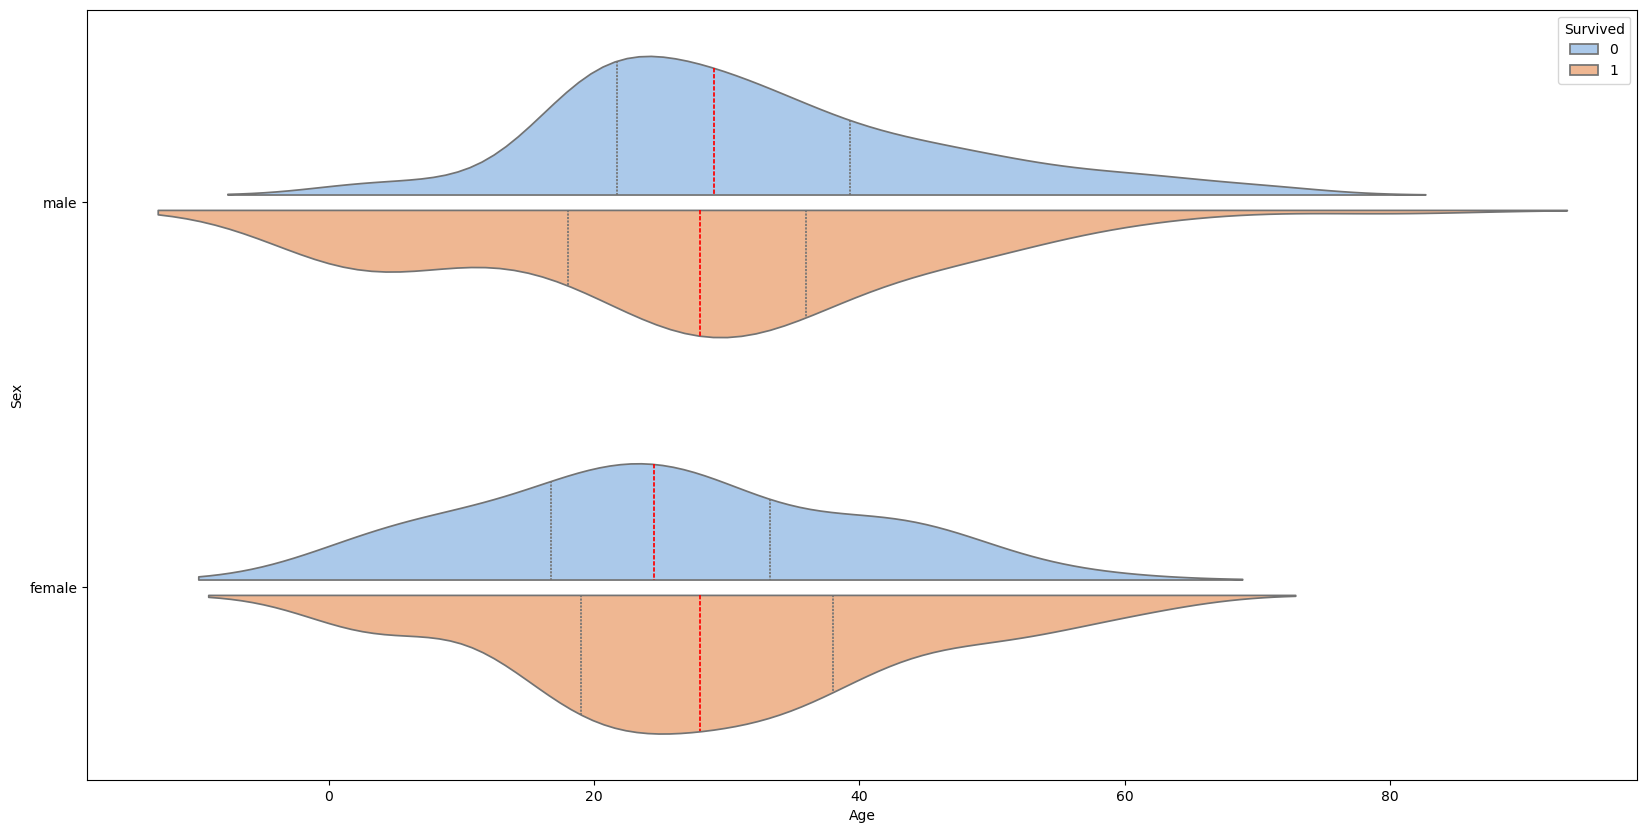

In [72]:
plt.figure(figsize=(20,10))
ax = sns.violinplot(data=train, x="Age", y="Sex", hue="Survived", split=True, gap=0.1, inner = "quartile")
for l in ax.lines[1::3]:
    l.set_color('red')
#     print(l)
    # if 'med' in line.get_label():  # Identify median line based on label
    #     line.set_color('red')  # Change to your preferred color
# plt.show()


<Axes: xlabel='cabin_share_flg', ylabel='count'>

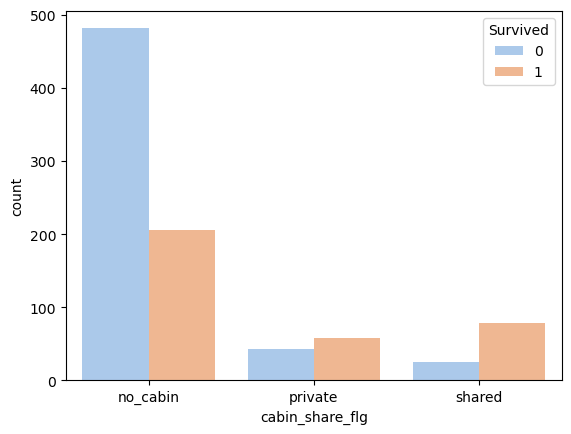

In [31]:
# value_counts = train['cabin_share_flg'].value_counts()
# ax = sns.barplot(x=value_counts.index, y=value_counts.values)
sns.countplot(data = train, x='cabin_share_flg', hue='Survived')

In [32]:
import sys
import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.insert(0, parent_dir)
sys.path = list(dict.fromkeys(sys.path))

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
train = pd.read_csv("./data/train.csv")

f_get_name_title = FunctionTransformer(get_name_title)
f_get_special_title_flg = FunctionTransformer(get_special_title_flg)
f_get_family_flg = FunctionTransformer(get_family_flg)
f_get_cabin_share_flg = FunctionTransformer(get_cabin_share_flg)
preprocessing = ColumnTransformer([
    ('name_title', f_get_name_title, ['Name']),
    ('special_title_flg', f_get_special_title_flg, ['Name']),
    ('family_flg', f_get_family_flg, ['SibSp', 'Parch'])
])

preproc_pipeline = Pipeline([
    ('transformer', preprocessing)
])

transformed = preproc_pipeline.fit_transform(train)
transformed_df = pd.DataFrame(transformed, columns=[name for name, transformer, columns in preprocessing.transformers])  # Update column names

transformed_df

,name_title,special_title_flg,family_flg
0,Mr,generic,SibSp
1,Mrs,generic,SibSp
2,Miss,generic,no_fam
3,Mrs,generic,SibSp
4,Mr,generic,no_fam
...,...,...,...
886,Rev,special,no_fam
887,Miss,generic,no_fam
888,Miss,generic,big_fam
889,Mr,generic,no_fam
